# Solution
### Location
I've selected the city of Bengaluru, where I reside, as the region of interest (bounding box defined [here](http://bboxfinder.com/#12.894477,77.507515,13.054061,77.709732) ).
### Environmental phenomena
I've selected air quality, and breaking down the trends of different air pollutants in Bengaluru. 


This solution will use satellite data, ground sensor data, mobility trends and the varying lockdown regulations, to identify the impact of the decrease in social and economic activity caused by the Covid-19 lockdown, on the levels of air pollution in Bengaluru. 

In [1]:
import datetime as dt
from glob import iglob
from os.path import join
import random
import requests
import time
import warnings
warnings.filterwarnings("ignore")

from IPython.display import display, Image
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd 

# Satellite observations
### Data
We start by looking at Aerosol optical thickness data from MODIS (Moderate Resolution Imaging Spectroradiometer) on NASA's Terra satellite [(source).](https://neo.sci.gsfc.nasa.gov/view.php?datasetId=MODAL2_M_AER_OD) 

The data is available on a daily level for varying areas, so we look at it aggregated on the monthly level for a comprehensive picture. We're using this data in CSV format, with a value from 0-1 representing the relative Aerosol Optical thickness, for each 0.1°x 0.1° box on the surface of the Earth. We consider the boxes containing the Bengaluru Urban district (12.85°-13.15°N, 77.5°-77.75°E), and even after looking on a monthly level we still have missing/limited data for the latter half of 2019 and 2020.

### Assumption
Unpredictable cloud coverage is a common source of satellite observation error - however  MODIS characteristics allows excellent cloud rejection while maintaining high statistics of cloud-free pixels, so we assume that this source of error is negligible.

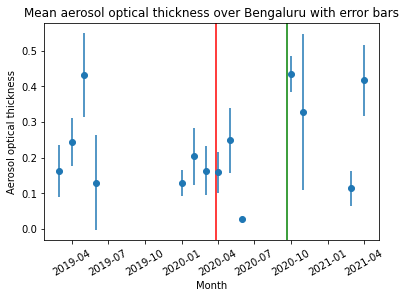

In [2]:
path = 'data'
input_files = sorted(list(iglob(join(path, '**', '*.SS.csv'), recursive=True)))

months = [ input_file[input_file.index('20'): input_file.index('20')+ 7] for input_file in input_files]

# Defining bounding box of area of interest
x1,y1,x2,y2 = 77.507515,12.894477,  77.709732,13.054061 # bounding box of Bengaluru Urban
means = []
stds = []
for month in months:
    csv = pd.read_csv(join(path, f'MODAL2_M_AER_OD_{month}-01_rgb_3600x1800.SS.CSV') )
    margin=0.1  # 0.1 for minimum box around Bengaluru, can increase to include more surrounding area
    # Filter relevant columns based on bounding box
    cols = [lon for lon in csv.columns if lon> str(x1-margin) and lon< str(x2+margin) ]
    # Filter relevant rows based on bounding box and flatten
    values = csv[(csv['lat/lon']>y1-margin) & (csv['lat/lon']<y2+margin) ][cols].values.flatten()
    # Filter values of 9999 representing no measurement
    values = [value for value in values if value <= 1]
    means.append(np.mean(values))
    stds.append(np.std(values))
dates = [dt.datetime.strptime(month, '%Y-%m').date() for month in months]
plt.errorbar(dates, means, stds, linestyle='None', marker='o')
plt.title('Mean aerosol optical thickness over Bengaluru with error bars')
plt.xlabel('Month')
plt.ylabel('Aerosol optical thickness')
plt.xticks(rotation=30)
plt.axvline(x=dt.date(2020,3,26), color='red') #Lockdown
plt.axvline(x=dt.date(2020,9,21), color='green') #Unlock 4.0, metro, schools restaurants open
plt.show()

### Observations
- We can see that March values are almost identical for 2019 and 2020.
- After the lockdown was enforced at the end of March 2020, aerosol levels for April, May, June are all significantly lower than in 2019.
- After almost full relaxation of lockdowns, we see levels increasing again, till 2021 March and April have almost the exact same aerosol levels as 2019. 
- A number of months have no data at all, and some have limited data, which can also be seen by some abnormally large error bars (Note: Jun 2020 has just 1 grid square of non-null data).

### Inferences
- Aerosol levels are highly responsive to changes in human social and economic activity. 
- We know that common aerosols like soot and sulfates are generated when we burn fossil fuels - for transport or in factories. We can conclude that aerosol levels are artifically higher due to human activity.

# Ground observations
### Data
We now look at ground sensors, aggregated and exposed via API by [OpenAQ](https://openaq.org/#/). There are 15 reference-grade government sensors available here in Bengaluru, with a variety of pollutants tracked (NO<sub>2</sub>, SO<sub>2</sub>, CO etc). Most of these have data mid-2019 onwards, however we first take a look at the sensor at Silk Board (#3 in the map below), an area in South Bengaluru famous for perpetual traffic jams - or it was before the pandemic. 

### Analysis
The other reason we're isolating Silk Board data is that it's the only one here that has data from the first half of 2019 - so that we have a baseline for the periods immediately before and after March 2020, when lockdown was imposed. This time, because we have a large number (hundreds to thousands) of observations for each period, we can get a more accurate idea of the distribution of the mean emissions, instead of reducing it to just 1 number. We randomly pick 100 rows (with replacement), average them to get a mean, and repeat this 500 times to get the bootstrapped distribution of the mean.

### Assumptions
There were no other anomalous events majorly impacting human activity in the 2019 data, so we can safely use it as a reference.

### Locations of ground sensors used

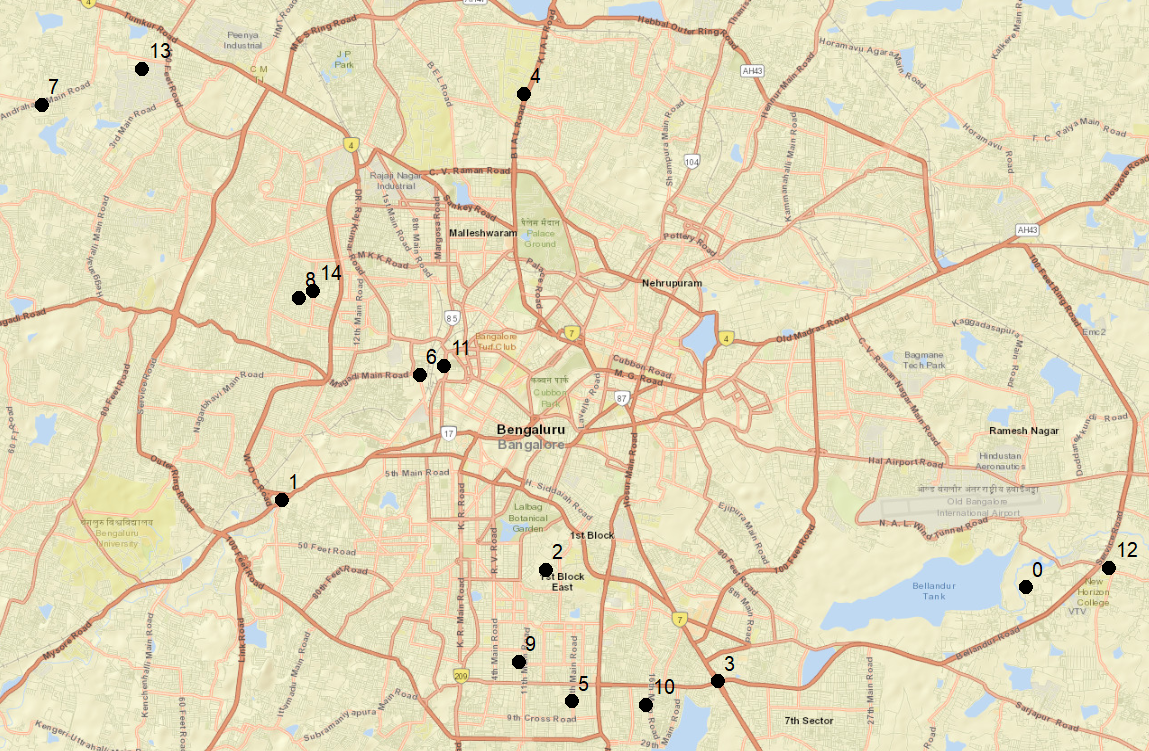

In [3]:
# Plotted with ArcMap 10.6.1
Image("data/blr_sensors_locs.png")

In [4]:
# Get locations of all sensors in Bengaluru
results = requests.get('https://api.openaq.org/v2/locations?city=Bengaluru&limit=1000').json()
loc_df = pd.DataFrame(results['results'])
loc_ids = loc_df['id'].to_list()

# Write locations of sensors to open in ArcMap for initial map of locations
loc_df['latitude'] = loc_df['coordinates'].apply(lambda x: x['latitude'])
loc_df['longitude'] = loc_df['coordinates'].apply(lambda x: x['longitude'])
loc_df[['latitude', 'longitude']].to_csv('blr_sensors.csv')

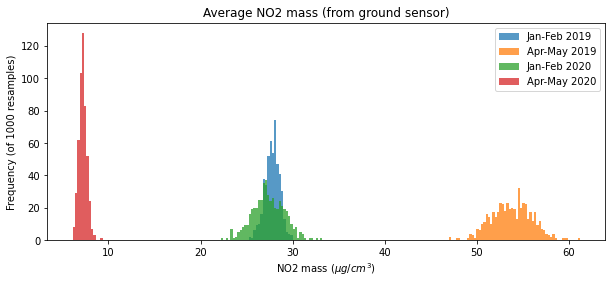

In [5]:
def bootstrap(series, size: int = 100, samples: int = 500, **kwds):
    data = list(series.values)
    samplings = [random.sample(data, size) for _ in range(samples)]
    means = np.array([np.mean(sampling) for sampling in samplings])
    # Fixing constant bin width to ensure each histogram has the same area for consistency
    binwidth = 0.25
    bins = np.arange(min(means), max(means) + binwidth, binwidth)
    plt.hist(means, bins=bins, **kwds)

# NO2 mass data from Silk Board sensor
results = requests.get('https://api.openaq.org/v2/measurements?location_id=6975&date_from=2019-01-01&date_till=2020-07-01&parameter=no2&limit=100000').json()
x = pd.DataFrame(results['results'])
x['utc'] = x['date'].apply(lambda y:y['utc'])
plt.figure(figsize=(10,4))
bootstrap(x[(x['utc']>'2019-01-01') & (x['utc']<'2019-03-01')]['value'], label='Jan-Feb 2019', alpha=0.75)
bootstrap(x[(x['utc']>'2019-04-01') & (x['utc']<'2019-06-01')]['value'], label='Apr-May 2019', alpha=0.75)

bootstrap(x[(x['utc']>'2020-01-01') & (x['utc']<'2020-03-01')]['value'], label='Jan-Feb 2020', alpha=0.75)
bootstrap(x[(x['utc']>'2020-04-01') & (x['utc']<'2020-06-01')]['value'], label='Apr-May 2020', alpha=0.75)
plt.title('Average NO2 mass (from ground sensor)')
plt.xlabel(r'NO2 mass $(\mu g/cm^3)$')
plt.ylabel('Frequency (of 1000 resamples)')
plt.legend()
plt.show()

### Observations
- We see that the pre-lockdown period of Jan-Feb in 2020 has a high degree of overlap with the reference period of Jan-Feb in 2019.
- In the reference period we see Apr-May having much higher NO<sub>2</sub> levels (~2x) than Jan-Feb.
- In 2020, we see Apr-May having much lower NO<sub>2</sub> levels (<0.5x) than Jan-Feb.
- All the histograms have the same area: Apr-May 2020 is narrower because NO2 mass can only be positive, but since the levels are so low, there's a much smaller range of observed values available.

### Inference
NO<sub>2</sub> emissions in Apr-May 2020 saw a large mismatch from what was expected based on the previous trend of 2020 v 2019 emissions. This allows us to more clearly point to the pandemic induced lockdown, which was the major driver of change in human activities, as the proximate cause of the drop in NO<sub>2</sub> levels.


In [6]:
def plot_param(x, name, unit, ax):
    """Generate plot analysing air quality parameter density trends."""
    x['day'] = x['date'].apply(lambda y: dt.datetime.strptime(y['utc'][:10], '%Y-%m-%d' ).date() )
    # Winsorize data 
    x['value'] = x['value'].clip(lower=0, upper=x['value'].quantile(0.95))

    # Aggregate and calculate daily average
    day_agg = x.groupby(['day']).mean()
    day_agg.sort_index(inplace=True)
    ax.scatter(day_agg.index, day_agg['value'], s=10)
    ax.set_title(f'Daily avg {name} measurements')
    ax.set_ylabel(f'{name} {unit}')
    xtick_labels = [mdates.num2date(y).date() for y in ax.get_xticks()] #Fix auto conversion to matplotlib dates
    ax.set_xticklabels(xtick_labels, rotation = 30)
    ax.axvline(x=dt.date(2020,3,26), color='red') #Lockdown
    ax.axvline(x=dt.date(2020,9,21), color='green') #Unlock 4.0, metro, schools restaurants open
    ax.axvline(x=dt.date(2021,4,22), color='red') #2nd wave lockdown
    ax.axvline(x=dt.date(2021,6,14), color='green') #2nd wave unlock

30.980544567108154 seconds taken totally.


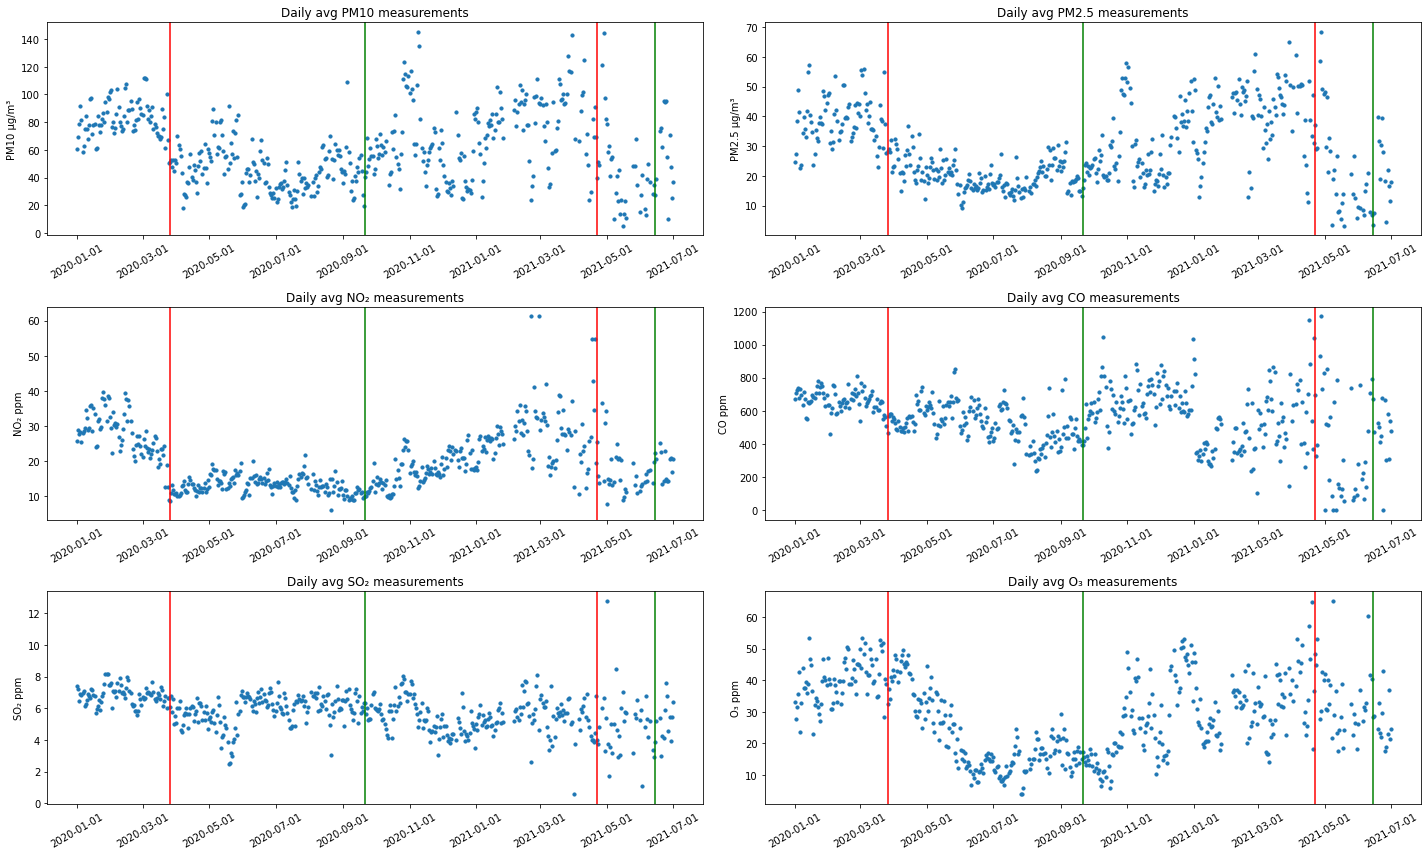

In [7]:
# Get data for all parameters
results = requests.get('https://api.openaq.org/v2/parameters').json()
params_df = pd.DataFrame(results['results'])
params_df = params_df[params_df['isCore']]

# Defining 
start_date = '2020-01-01'
end_date = '2021-07-01'
time0 = time.time()
ctr = 0
fig, axes = plt.subplots(3, 2, figsize=(20,12))
for index, row in params_df.iterrows():
    time1 = time.time()
    dfs = []
    for loc_id in loc_ids:
        results = requests.get(f'https://api.openaq.org/v2/measurements?location_id={loc_id}&date_from={start_date}&date_till={end_date}&parameter={row["name"]}&limit=100000').json()
        if len(results['results']) == 0:
            continue
        df = pd.DataFrame(results['results'])
        dfs.append(df)
        time2 = time.time()
    if len(dfs) == 0:
        continue
    values = pd.concat(dfs)
    #print(f'{len(values)} rows of {row["displayName"]} observations')
    plot_param(values, row['displayName'], row['preferredUnit'], axes[int(ctr/2), ctr%2])
    ctr = ctr + 1
    time2 = time.time()
    #print(f'{time2-time1} seconds taken for {row["displayName"]}.\n')
fig.tight_layout()
time3 = time.time()
print(f'{time3-time0} seconds taken totally.')

### Observations
- We see the same general pattern across all the above graphs of the 6 pollutants considered: 
    - A significant drop after Mar 26th, halving most of the pollutant levels.
    - A slow increase after September.
    - Peaking in April and then drastically falling again.
    - Climbing back up in June.
- We see the sharpest changes in NO<sub>2</sub> and O<sub>3</sub>, significant changes in PM<sub>2.5</sub>, PM<sub>10</sub> and CO, and negligible changes in SO<sub>2</sub>.
- CO also has a sharp drop at December end.

### Inferences
- These large changes in air pollutant levels exactly align with the impositions of lockdown (in red) and the gradual liftings of restrictions (in green).
- When NO<sub>2</sub> reacts with other pollutants in the presence of sunlight, it forms O<sub>3</sub>, ewhich could explain the sharp changes in O<sub>3</sub>.


# Mobility trends

Google has daily [Community Mobility Reports](https://support.google.com/covid19-mobility#topic=9822927) generated showing the impact of Covid-19 restrictions on mobility on a district level, compared to a pre-pandemic baseline. It doesn't store historical reports from more than a few months back so we cannot refer to 2020 data, but we can look at a couple of relevant snapshots from the second wave in India.

Below are the reports for [30<sup>th</sup> April, 2021](https://www.gstatic.com/covid19/mobility/2021-04-30_IN_Karnataka_Mobility_Report_en-GB.pdf) and
[25<sup>th</sup> June, 2021](https://www.gstatic.com/covid19/mobility/2021-06-25_IN_Karnataka_Mobility_Report_en-GB.pdf) respectively.


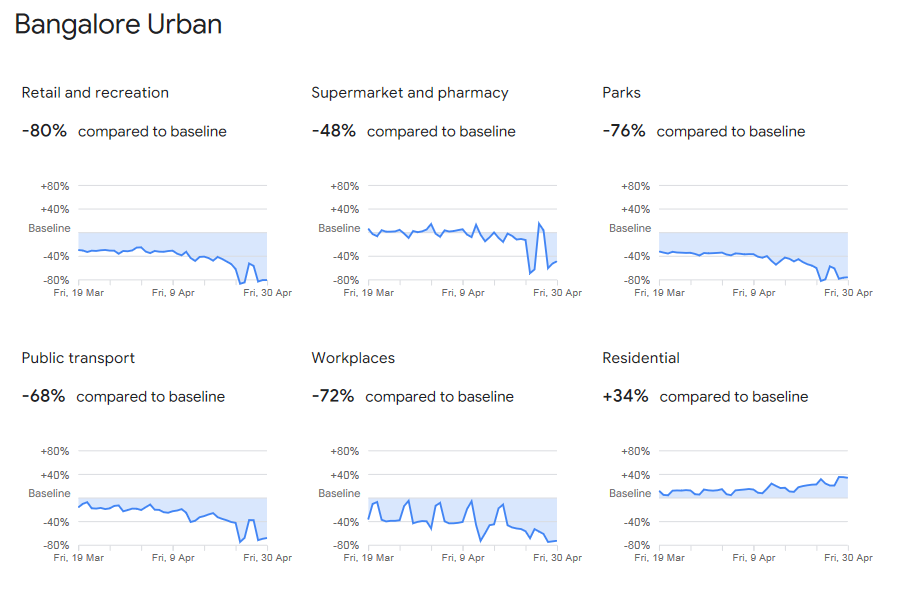

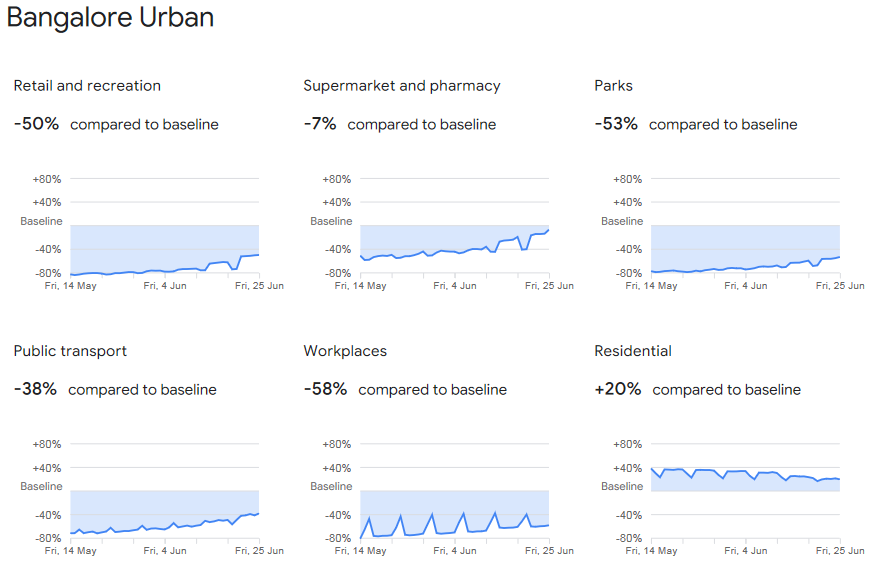

In [8]:
im1 = Image("data/blr_mobility_apr.PNG") 
im2 = Image("data/blr_mobility_june.PNG") 
display(im1, im2)

### Observations
- 23<sup>rd</sup> April saw lockdown announced in Bengaluru, and we can see a corresponding drop in mobility in all sectors but residential, as people were confined to their homes.
- After a reduction in Covid cases, the lockdown was lifted 14<sup>th</sup> June, after which we can see the trend of mobility picking up again.

### Inferences
- This helps us take the established link, between the drop in air pollutant levels and the imposition/lifting of lockdown, a step further to connect to the same trends in mobility.
- All of the above pollutants are found in vehicular emissions, and burning of fossil fuels in general, which explains the causation for the correlation that we have determined.

# Conclusion
We've analysed satellite and ground sensor data to get a clear picture of varying levels of major air pollutants in Bengaluru. There were drastically reduced human activity in different lockdown periods, which we also verified by looking at mobility data. We used these time periods of COVID-19 restrictions as a control, to test what affect human activity has on these air pollutant levels. Juxtaposing the trends of air pollutants and human activity shows us that human activity is driving unnaturally high air pollutant levels. 
